Development and testing of my implementation of a random forest regressor. Done with guidance from fast.ai's Introduction to Machine Learning for Coders.

### Imports

In [1]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import export_graphviz

# draw_tree is from fast.ai library.
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of an SK-Learn random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

### Mock data

Make some fake data to test my regressor.

In [6]:
def make_data(n):
    x1 = np.random.uniform(0, 1, n)
    x2 = np.random.uniform(0,100, n)
    
    y = x1 + x2/100 + np.random.normal(0, 0.2, n)
    
    #np.random.shuffle(x1)
    #np.random.shuffle(x2)
    
    x1 = x1[...,None]
    x2 = x2[...,None]
    x = np.concatenate((x1, x2), axis=1)

    x = pd.DataFrame(x)
    #x.columns = ['var1', 'var2']

    #display(pd.concat([x,pd.DataFrame(y)], axis=1))
    return x, y

In [7]:
x, y = make_data(20)
display(pd.concat([x,pd.DataFrame(y)], axis=1))

,0,1,0
0,0.361118,24.770649,0.781331
1,0.514930,15.975921,0.778690
2,0.144539,91.762824,0.966605
3,0.628277,3.631903,0.282235
4,0.492055,66.489693,1.341162
5,0.557544,82.343755,1.327503
6,0.044385,80.511219,0.956561
7,0.170103,29.826412,0.724090
8,0.197030,75.545241,0.771346
9,0.528096,23.611384,0.613811


### Decision tree

In [8]:
class Tree:
    def __init__(self, idx, x, y, leaf_size):
        self.idx = idx
        self.x, self.y = x, y
        self.leaf_size = leaf_size
        self.isleaf = len(idx)
        self.score = float('inf')
        
        if len(self.idx) > self.leaf_size:
            self.split()
        else:
            self.isleaf = True
            self.mean = np.sum(y[idx] / len(idx))
            
    def split(self):
        for i in range(self.x.shape[1]):
            self.find_split(i)
        """RECURSION GOES HERE"""
    
    def find_split(self, var_idx):    
        """NEED TO WRITE"""
        
    def __repr__(self):
        try:
            self.split_var
            return f'Variable to index split on: {self.split_var} . Value to split on:{self.split_val}'
        except:
            return 'None'

In [9]:
atree = Tree(np.asarray(np.arange(0,20)), x, y, 1)
atree

None

Now we add in the find_split function.

In [10]:
def find_split(self, var_idx):    
    '''greater to or equal to split_val go right
    if less than split_val go left'''
    # Extract an array of the current x and y values
    x = self.x.values[self.idx, var_idx]
    y = self.y[self.idx]
    #sortidx = np.argsort(x)
    #x, y, idx_sorted = x[sortidx], y[sortidx], self.idx[sortidx]

    for j in range(len(self.idx)):
        lhs = y[x<=x[j]]
        rhs = y[x>x[j]]

        if not (len(lhs) == 0 or len(rhs) == 0):
            mean_lhs = np.sum(lhs) / len(lhs)
            mean_rhs = np.sum(rhs) / len(rhs)     
            new_score = np.sum((lhs - mean_lhs)**2) + np.sum((rhs - mean_rhs)**2)
            if new_score < self.score:
                self.score = new_score
                self.split_var = var_idx
                self.split_val = (x[j] + np.min(x[x>x[j]])) / 2

Tree.find_split = find_split

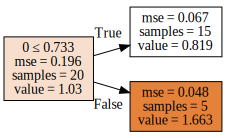

Variable to index split on: 0 . Value to split on:0.7327054407137128

In [11]:
x, y = make_data(20)
#display(pd.concat([x,pd.DataFrame(y)], axis=1))

m = RandomForestRegressor(n_estimators=1, bootstrap=False , max_depth=1)
m.fit(x,y)
draw_tree(m.estimators_[0], x, precision=3)    

atree = Tree(np.arange(len(y)), x, y, 1)
atree

My regressor splits on the same variable as SK-Learn's. Next add recursion.

In [12]:
def split(self):
    for i in range(self.x.shape[1]):
        self.find_split(i)
    split_col = self.x.values[self.idx, self.split_var]
    idx_lhs = np.nonzero(split_col <= self.split_val)[0]
    idx_rhs = np.nonzero(split_col > self.split_val)[0]
    self.lhs = Tree(self.idx[idx_lhs], self.x, self.y, self.leaf_size)
    self.rhs = Tree(self.idx[idx_rhs], self.x, self.y, self.leaf_size)
    
Tree.split = split

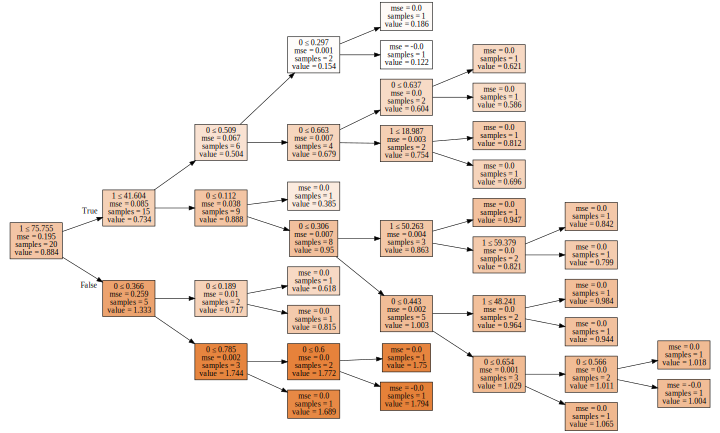

In [27]:
x, y = make_data(20)
m = RandomForestRegressor(n_estimators=1, bootstrap=False)
m.fit(x,y)
draw_tree(m.estimators_[0], x, precision=3)    

atree = Tree(np.asarray(np.arange(0,20)), x, y, 1)

In [28]:
atree.rhs

Variable to index split on: 0 . Value to split on:0.36595410010470125

By comparising the output of my decision tree at different depths with the diagram we can see it is working correctly. Next we need to add functionality to predict a given row.

In [30]:
def predict_row(self, row):
    if self.isleaf == True:
        return self.mean
    else:
        if row[self.split_var]  > self.split_val:
            return self.rhs.predict_row(row)
        else:
            return self.lhs.predict_row(row)
        
Tree.predict_row = predict_row

In [31]:
test_row_array = np.array([0.2,20])
test_row = pd.DataFrame(test_row_array[None])
test_row
test_row_array

array([ 0.2, 20. ])

In [32]:
atree = Tree(np.arange(len(y)), x, y, 1)
print(atree.predict_row(test_row_array))
m.predict(test_row)

0.18551853649828143


array([0.18552])

Same prediction. Now we want to be able to predict a whole test set of data.

In [37]:
def predict(self, x_test):
    data = x_test.values.tolist()
    predictions = []
    for row in data:
        predictions.append(self.predict_row(row))
    return predictions

In [38]:
Tree.predict = predict

In [39]:
#x, y = make_data()
#atree = Tree(np.asarray(np.arange(0,20)), x, y, 1)
#m = RandomForestRegressor(n_estimators=1, bootstrap=False)
#m.fit(x,y)
x, y = make_data(50)
m.predict(x) - np.asarray(atree.predict(x))

array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     , -0.0405 ,  0.     ,  0.     ,  0.     ,  0.     ,  0.11573,  0.     ,  0.     ,  0.11573,
        0.     , -0.04247,  0.0405 ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     , -0.11573,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ])

Similar results. Differences are likely from chosing the variable to split on in cases where there are only 2 samples left.

### Final function

In [40]:
class Tree:
    def __init__(self, idx, x, y, leaf_size):
        self.idx = idx
        self.x, self.y = x, y
        self.leaf_size = leaf_size
        self.isleaf = len(idx)
        self.score = float('inf')
        
        if len(self.idx) > self.leaf_size:
            self.split()
        else:
            self.isleaf = True
            self.mean = np.sum(y[idx] / len(idx))
            
    def split(self):
        for i in range(self.x.shape[1]):
            self.find_split(i)
        split_col = self.x.values[self.idx, self.split_var]
        idx_lhs = np.nonzero(split_col <= self.split_val)[0]
        idx_rhs = np.nonzero(split_col > self.split_val)[0]
        self.lhs = Tree(self.idx[idx_lhs], self.x, self.y, self.leaf_size)
        self.rhs = Tree(self.idx[idx_rhs], self.x, self.y, self.leaf_size)
    
    def find_split(self, var_idx):    
        '''greater to or equal to split_val go right
        if less than split_val go left'''

        x = self.x.values[self.idx, var_idx]
        y = self.y[self.idx]
        #sortidx = np.argsort(x)
        #x, y, idx_sorted = x[sortidx], y[sortidx], self.idx[sortidx]

        for j in range(len(self.idx)):
            lhs = y[x<=x[j]]
            rhs = y[x>x[j]]

            if not (len(lhs) == 0 or len(rhs) == 0):
                mean_lhs = np.sum(lhs) / len(lhs)
                mean_rhs = np.sum(rhs) / len(rhs)     
                new_score = np.sum((lhs - mean_lhs)**2) + np.sum((rhs - mean_rhs)**2)
                if new_score < self.score:
                    self.score = new_score
                    self.split_var = var_idx
                    self.split_val = (x[j] + np.min(x[x>x[j]])) / 2

    def predict_row(self, row):
        if self.isleaf == True:
            return self.mean
        else:
            if row[self.split_var]  > self.split_val:
                return self.rhs.predict_row(row)
            else:
                return self.lhs.predict_row(row)
    
    def predict(self, x_test):
        data = x_test.values.tolist()
        predictions = []
        for row in data:
            predictions.append(self.predict_row(row))
        return predictions

    def __repr__(self):
        try:
            self.split_var
            return f'Variable to index split on: {self.split_var} . Value to split on:{self.split_val}'
        except:
            return f'Leaf. Mean is: {self.mean}'

In [41]:
x, y = make_data(50)

atree = Tree(np.arange(len(y)), x, y, 1)
m = RandomForestRegressor(n_estimators=1, bootstrap=False)
m.fit(x,y)

x, y = make_data(20)
m.predict(x) - np.asarray(atree.predict(x))

array([ 0.     ,  0.     ,  0.12374,  0.     ,  0.     ,  0.     ,  0.05233,  0.     ,  0.     ,  0.     ,
       -0.05634,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ])

### Random Forest

In [46]:
class MyForest:
    def __init__(self, ntrees, leaf_size, x, y, sample_size):
        self.ntrees = ntrees
        self.leaf_size = leaf_size
        self.x = x
        self.y = y
        self.sample_size = sample_size
        self.trees = self.tree_ensemble()
        
    def tree_ensemble(self):
            idxs = [np.random.permutation(len(self.y))[:self.sample_size] for i in range(self.ntrees)]
            return [Tree(idxs[i], self.x, self.y, self.leaf_size) for i in range(self.ntrees)]
    
    def predict(self, x_test):
        return np.mean([t.predict(x_test) for t in self.trees], axis=0)
    
    def __repr__(self):
            return f'ntrees {self.ntrees}, leaf size {self.leaf_size}, sample size {self.sample_size}'
   

In [94]:
x, y = make_data(200)
a = MyForest(10, 1, x, y, 100)
m = RandomForestRegressor(n_estimators=10, bootstrap=True)
m.fit(x,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [109]:
x_test, y_test = make_data(50)
np.std(a.predict(x_test) - y_test)

0.1867857249341847

Makes sense as the random compenent of y is uniform distribution with a standard deviation of 0.2.

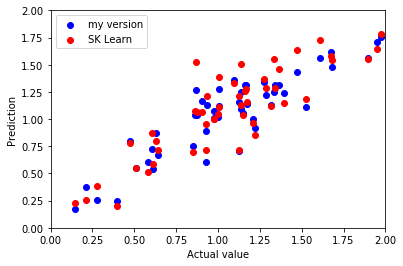

In [110]:
plt.figure()
plt.scatter(y_test, a.predict(x_test), color ='b', label='my version')
plt.scatter(y_test, m.predict(x_test), color ='r', label='SK Learn')
plt.xlabel('Actual value')
plt.ylabel('Prediction')
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend()
plt.show()

In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
x, y = make_data(200)
a = MyForest(10, 1, x, y, 100)
m = RandomForestRegressor(n_estimators=10, bootstrap=True)
m.fit(x,y)

In [109]:
x_test, y_test = make_data(50)
np.std(a.predict(x_test) - y_test)

0.1867857249341847

Makes sense as the random compenent of y is uniform distribution with a standard deviation of 0.2.

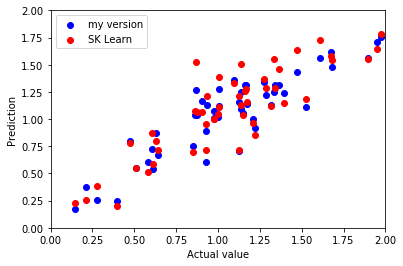

In [110]:
plt.figure()
plt.scatter(y_test, a.predict(x_test), color ='b', label='my version')
plt.scatter(y_test, m.predict(x_test), color ='r', label='SK Learn')
plt.xlabel('Actual value')
plt.ylabel('Prediction')
plt.xlim(0,2)
plt.ylim(0,2)
plt.legend()
plt.show()